In [3]:
from pandas import read_csv
from matplotlib.pyplot import subplots, yticks
from numpy import arange, linspace, zeros

from scipy.signal import butter, sosfilt


In [4]:
df = read_csv("../data/EEG_background.txt", delim_whitespace=True) 

df.head()


,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,...,Pz,A1,A2,EKG,ATM,EO1,EO2,EM1,EM2,PHO
0,-7.4546,22.8428,6.28159,15.6212,7.98755,22.4034,-7.7884,32.6146,35.6545,24.8028,...,-11.775,38.8505,35.2711,2.35162,14.1170,13.6331,13.7021,12.9109,13.7034,9.37573
1,-11.1060,21.4828,6.89088,15.0562,10.10910,22.5443,-7.1574,34.1495,34.8749,29.5059,...,-12.350,44.9804,61.4472,1.89293,14.2920,13.7184,13.7942,13.0194,13.7628,9.44731
2,-14.4000,20.0907,7.94856,14.1624,13.00190,21.6666,-6.1377,34.6890,34.1256,33.6971,...,-13.006,46.2484,79.1628,1.22726,14.4623,13.7995,13.8982,13.1116,13.8239,9.51796
3,-17.2380,18.7206,9.36857,13.0093,16.52820,19.9170,-4.6946,34.2955,33.6028,37.5240,...,-13.580,43.3831,88.4718,0.30236,14.6182,13.8759,14.0155,13.1927,13.8914,9.58770
4,-19.5540,17.4084,11.06040,11.6674,20.51280,17.4778,-2.7760,33.1315,33.5562,41.1388,...,-13.886,36.7796,89.8117,-0.85890,14.7537,13.9521,14.1399,13.2692,13.9652,9.65654


In [5]:
sr = 256

duration = 5

df_np = df.to_numpy()

data = df_np[:duration*sr, :4]

data.shape

(1280, 4)

In [6]:
def plot_series(data, sr):
    '''
    Time series plot of multiple time series
    Data are normalised to mean=0 and var=1 
    
    data: nxm numpy array. Rows are time points, columns are channels
    sr: sampling rate, same time units as period
    '''

    from numpy import flip

    samples = data.shape[0]
    sensors = data.shape[1]
    
    period = samples // sr

    time = linspace(0, period, period*sr)

    offset = 5 # for mean=0 and var=1 normalised data

    # Calculate means and standard deviations of all columns
    means = data.mean(axis=0)
    stds = data.std(axis=0)

    # Plot each series with an offset of 2 times the standard deviations
    fig, ax = subplots(figsize=(5, 3))

    ax.plot(time, (data - means)/stds + offset*arange(sensors-1,-1,-1));

    ax.plot(time, zeros((samples, sensors)) + offset*arange(sensors-1,-1,-1),'--',color='gray');
    
    yticks([]);

    ax.set(xlabel='Time')
    ax.set_yticks(offset*arange(sensors))
    ax.set_yticklabels(flip(arange(sensors)+1))


In [7]:
def data_filter(data, sr):
    """
    Default filtering of multiple time series. 
    Low cut-off: high-pass
    High cut-off: Maximum is Nyquist frequency (sr / 2)

    data: nxm numpy array. Rows are time points, columns are channels
    sr: sampling rate   
    
    return: filtered data
    """

    low = 5
    high = sr / (2.0 + 0.001)
    order = 5

    filter_settings = [low, high, order]

    sos = butter(order, (low, high), btype='bandpass', fs=sr, output='sos')

    data_filt = zeros((data.shape[0], data.shape[1]))

    for index, column in enumerate(data.transpose()): 
        forward = sosfilt(sos, column)
        backwards = sosfilt(sos, forward[-1::-1])
        data_filt[:, index] = backwards[-1::-1]
        
    return data_filt
    

In [8]:
data_filtered = data_filter(data, sr)

print(data.shape, data_filtered.shape)

(1280, 4) (1280, 4)


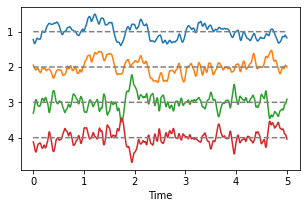

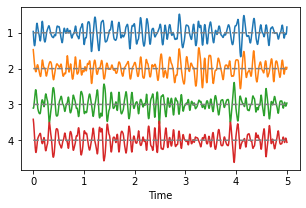

In [9]:
plot_series(data, sr)
plot_series(data_filtered, sr);

In [10]:
def data_filter_low(data, sr):
    """
    Low-pass filtering of multiple time series. 

    data: nxm numpy array. Rows are time points, columns are recordings
    sr: sampling rate, same time units as period
    cut_off: maximal frequency that passes
    
    return: filtered data
    """
    
    lower = 0.1
    upper = 20
    order = 5

    filter_settings = [lower, upper, order]

    sos = butter(order, (low,high), btype='bandpass', fs=sr, output='sos')

    data_filt = zeros((data.shape[0], data.shape[1]))

    for index, column in enumerate(data.transpose()): 
        forward = sosfilt(sos, column)
        backwards = sosfilt(sos, forward[-1::-1])
        data_filt[:, index] = backwards[-1::-1]
        
    return data_filt
    

In [11]:
def data_filter(data, sr, cut_off):
    """
    Low-pass filtering of multiple time series. 

    data: nxm numpy array. Rows are time points, columns are recordings
    sr: sampling rate, same time units as period
    cut_off: maximal frequency that passes
    
    return: filtered data
    """
    
    low = 0.1
    high = cut_off
    order = 5

    filter_settings = [low, high, order]

    sos = butter(order, (low,high), btype='bandpass', fs=sr, output='sos')

    data_filt = zeros((data.shape[0], data.shape[1]))

    for index, column in enumerate(data.transpose()): 
        forward = sosfilt(sos, column)
        backwards = sosfilt(sos, forward[-1::-1])
        data_filt[:, index] = backwards[-1::-1]
        
    return data_filt
    

(1280, 4) (1280, 4)


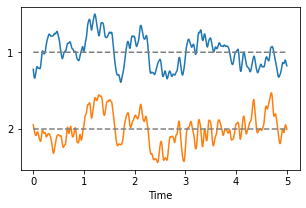

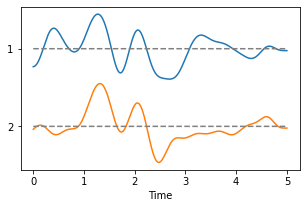

In [12]:
data_filt = data_filter(data, sr, 2)

print(data.shape, data_filt.shape)

plot_series(data[:, :2], sr)
plot_series(data_filt[:, :2], sr);